In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Lambda, Conv2D, MaxPool2D, BatchNormalization, concatenate, add, GlobalAvgPool2D, Dense
from tensorflow.keras import Model, Input, Sequential

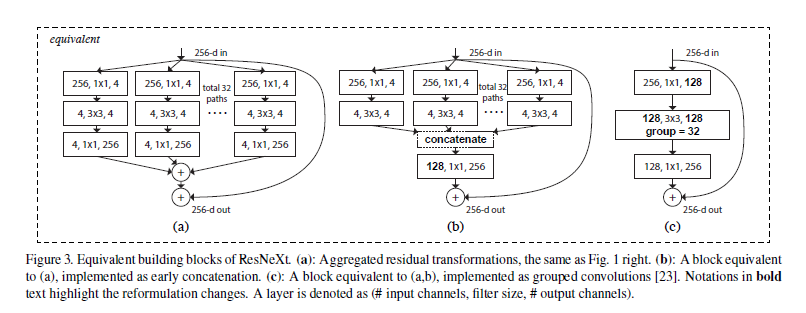
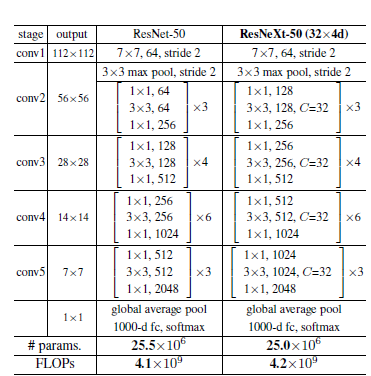

In [3]:
class GroupConv2D(tf.keras.layers.Layer):
    def __init__(self,input_channels,output_channels,kernel_size,
                padding='valid', strides=(1, 1),groups=1,**kwargs):
        # We initialize parameters and prepare layers with their settings
        super(GroupConv2D, self).__init__()

        # Corner Cases
        if not input_channels % groups == 0:
            raise ValueError("The input channels must be divisible by the no. of groups")
        if not output_channels % groups == 0:
            raise ValueError("The output channels must be divisible by the no. of groups")
        
        # Assign parameters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.groups = groups

        # Calculate the number of channels
        # 4 in both cases here
        self.group_in_num = input_channels // groups
        self.group_out_num = output_channels // groups
        
        # The list of conv2Ds with their settings 
        self.conv_list = []
        for i in range(self.groups):
            self.conv_list.append(
            Conv2D(
            filters=self.group_out_num,
            kernel_size = kernel_size,
            strides = strides,
            padding=padding)
            )

    # The function that implements the forward pass
    # Since we inherited tf.keras.layers.Layer
    def call(self, inputs, **kwargs):
        feature_map_list = []
        for i in range(self.groups):
            x_i = self.conv_list[i](
            inputs[:, :, :, i * self.group_in_num: (i+1)*self.group_in_num]
            )
            feature_map_list.append(x_i)
        
        # Concatenate the list of 32 groups each of 4 channels into 128 again
        out = concatenate(feature_map_list, axis=-1)
        
        return out


In [4]:
class ResNext_BottleNeck_C(tf.keras.layers.Layer):
    def __init__(self, filters, strides, groups):
        super(ResNext_BottleNeck_C, self).__init__()

        # Prepare 
        # 256, 1x1, 128 (filters)
        self.conv1 = Conv2D(filters=filters,
                            kernel_size=(1, 1),
                            strides=1,
                            padding='same'
                            )
        self.bn1 = BatchNormalization()

        # Group Conv, 123, 3x3, 128
        self.conv2 = GroupConv2D(
                            input_channels=filters,
                            output_channels=filters,
                            kernel_size=(3, 3),
                            strides=strides,
                            padding='same',
                            groups=groups)
        self.bn2 = BatchNormalization()

        # 128, 1x1, 246
        self.conv3 = Conv2D(filters=2*filters, # 2 * 128 = 256
                            kernel_size=(1, 1),
                            strides=1,
                            padding='same')
        self.bn3 = BatchNormalization()

        # Skip Connection to add the input
        self.shortcut_conv = Conv2D(filters=2*filters,
                            kernel_size=(1, 1),
                            strides=strides,
                            padding='same')
        self.shortcut_bn = BatchNormalization()

    def call(self, inputs, training=None):

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = tf.nn.relu(x)

        shortcut = self.shortcut_conv(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        output = tf.nn.relu(add([x, shortcut]))
        return output

In [6]:
def build_ResNext_block(filters, strides, groups, repeat_num):
    block = Sequential()
    block.add(ResNext_BottleNeck_C(filters=filters,
                                strides=strides,
                                groups=groups))

    for i in range(1, repeat_num):
        block.add(ResNext_BottleNeck_C(filters=filters,
                                strides=1,
                                groups=groups))    

    return block


In [8]:
NUM_CLASSES = 10

In [9]:
class ResNext(Model):
    def __init__(self, repeat_num_list, 
                 cardinality
                 ):

        if len(repeat_num_list) != 4:
            raise ValueError('The length of repeat_num_list must be 4')
        super(ResNext, self).__init__()

        # Aggressive Downsampling (/4)
        self.conv1 = Conv2D(filters=64,
                            kernel_size=7,
                            strides=2,
                            padding='same')
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPool2D(pool_size=3,
                            strides=2,
                            padding='same')
        
        # In the Strides, similar to ResNet, the downsampling that happens to the WH
        # at the beginning of each block does not happen at the first block, thus it is
        # the only one given strides = 1
        # Note that inside the 'build_ResNext_block' function, this parameter is
        # only used for the first conv layer and the rest have strides = 1

        self.block1 = build_ResNext_block(
                            filters=128,
                            strides=1,
                            groups=cardinality,
                            repeat_num = repeat_num_list[0])
        self.block2 = build_ResNext_block(
                            filters=256,
                            strides=2,
                            groups=cardinality,
                            repeat_num = repeat_num_list[1])
        self.block3 = build_ResNext_block(
                            filters=512,
                            strides=2,
                            groups=cardinality,
                            repeat_num = repeat_num_list[2])
        self.block4 = build_ResNext_block(
                            filters=1024,
                            strides=2,
                            groups=cardinality,
                            repeat_num = repeat_num_list[3])
        
        self.pool2 = GlobalAvgPool2D()
        self.fc = Dense(units=NUM_CLASSES, activation='softmax')

    def call(self, inputs, training=None):

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)

        x = self.pool2(x)
        x = self.fc(x)

        return x

In [10]:
def ResNext50():
    return ResNext(repeat_num_list=[3, 4, 6, 3],
                   cardinality=32
                   )

def ResNext101():
    return ResNext(repeat_num_list=[3, 4, 23, 3],
                   cardinality=32
                   )

resnext50 = ResNext50()
resnext101 = ResNext101()

In [11]:
dummy_in = tf.random.uniform((10, 224, 224, 3))

for model in [resnext50, resnext101]:
    out = model(dummy_in)
    print(model.count_params())

37708042
74874122


* ResNeXt Class is the original network that inherits the Model  
* ResNext_BottleNeck_C Class is the version cont. grouped convolutions

In [12]:
resnext50.summary()

Model: "res_next"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 sequential (Sequential)     (10, 56, 56, 256)         344832    
                                                                 
 sequential_1 (Sequential)   (10, 28, 28, 512)         2004992   
                                                                 
 sequential_2 (Sequential)   (10, 14, 14, 1024)        123

In [13]:
dummy_in = tf.random.uniform((10, 224, 224, 3))

for model in [resnext50, resnext101]:
    out = model(dummy_in)
    print(model.count_params())

37708042
74874122
